In [ ]:
import pandas as pd
import requests
import zipfile
import io
import os

# Download the zip file from Google Drive
url = 'https://drive.google.com/uc?export=download&id=1FHp1opVOqcI_HU0HLPv4WRn8e4kEtuI7'

response = requests.get(url)

# Extract the zip file content directly from the response
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall()

# Load the data from the Excel files in the extracted directory
data_frames = {}
for root, dirs, files in os.walk('.'):
    for file_name in files:
        if file_name.endswith('.xlsx'):
            file_path = os.path.join(root, file_name)
            data_frames[file_name] = pd.read_excel(file_path)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler

scaler = MinMaxScaler()

# Columns to normalize
columns_to_normalize = ['illusion 1', 'illusion 2', 'illusion 3', 'illusion 4']

# Normalize the specified columns in each data frame
for key in data_frames.keys():
    if key.startswith('parameter_combinations_') and key.endswith('.xlsx'):
        data_frames[key][columns_to_normalize] = scaler.fit_transform(data_frames[key][columns_to_normalize])


In [ ]:
# Group by 'Noise Type', then calculate the mean for each illusion
average_illusions_data = []
for key in data_frames.keys():
    if key.startswith('parameter_combinations_') and key.endswith('.xlsx'):
        grouped_data = data_frames[key].groupby(['Noise Type']).mean().reset_index()
        average_illusions_data.append(grouped_data)

# Combine all the grouped data frames into one
data_combined = pd.concat(average_illusions_data, ignore_index=True)

In [ ]:
# Group by 'Noise Type', and calculate mean and standard deviation
grouped = data_combined.groupby(['Noise Type'])
mean_df = grouped.mean().reset_index()
std_dev_df = grouped.std().reset_index()

# Rename columns to indicate that these are means and standard deviations
mean_columns = {
    'illusion 1': 'illusion 1 mean',
    'illusion 2': 'illusion 2 mean',
    'illusion 3': 'illusion 3 mean',
    'illusion 4': 'illusion 4 mean'
}
std_dev_columns = {
    'illusion 1': 'illusion 1 std dev',
    'illusion 2': 'illusion 2 std dev',
    'illusion 3': 'illusion 3 std dev',
    'illusion 4': 'illusion 4 std dev'
}

mean_df.rename(columns=mean_columns, inplace=True)
std_dev_df.rename(columns=std_dev_columns, inplace=True)

# Optionally, you can merge the mean and standard deviation dataframes for a combined view
result_df = pd.merge(mean_df, std_dev_df, on=['Noise Type'])


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data - assuming 'result_df' is your DataFrame containing the data
data = result_df

# Replace 'px' with 'cs' in the 'Noise Type' column
data['Noise Type'] = data['Noise Type'].replace({
    'Dynamics_60fps_1px': 'Dynamics_60fps_1cs',
    'Statics_1px': 'Statics_1cs',
    'Statics_16px': 'Statics_16cs'
})

In [ ]:
# plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 15  # You can change the size to fit your needs

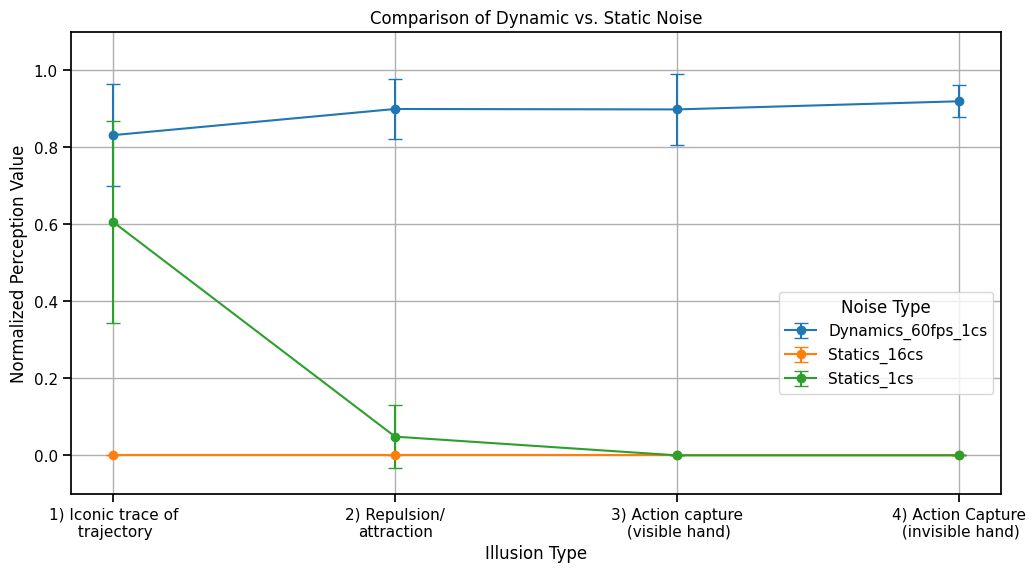

In [ ]:
# Define illusions and their respective columns for means and standard deviations
illusions = ['illusion 1', 'illusion 2', 'illusion 3', 'illusion 4']

display_labels = [
    '1) Iconic trace of\n trajectory',
    '2) Repulsion/\nattraction',
    '3) Action capture\n (visible hand)',
    '4) Action Capture\n (invisible hand)'
]


mean_cols = [f'{ill} mean' for ill in illusions]
std_dev_cols = [f'{ill} std dev' for ill in illusions]

# Setting up Seaborn context for larger fonts
sns.set_context("notebook")  # Options: paper, notebook, talk, poster (increasing size)

# Prepare the plot
plt.figure(figsize=(12, 6))

# Plot each noise type
for index, row in data.iterrows():
    means = row[mean_cols].values
    std_devs = row[std_dev_cols].values
    plt.errorbar(display_labels, means, yerr=std_devs, label=row['Noise Type'], marker='o', capsize=5)

plt.title('Comparison of Dynamic vs. Static Noise')
plt.xlabel('Illusion Type')
plt.ylabel('Normalized Perception Value')
plt.ylim(-0.1, 1.1)  # Adjust based on the maximum value seen in your dataset
plt.legend(title='Noise Type', loc='lower right', bbox_to_anchor=(1, 0.2))
plt.grid(True)
# plt.savefig('./Dynamics_vs_statics.svg', format='svg', bbox_inches='tight')
plt.show()
